In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import shap
import warnings
warnings.filterwarnings('ignore')

In [173]:
df = pd.read_csv('marvel_characters_dataset.csv')

Прежде чем заставить алгоритмы машинного обучения гадать, кто герой, кто злодей, а кто просто нейтрал, я решила провести глубокий визуальный анализ данных. Датасет включает разнообразные характеристики персонажей Marvel — от пола и роста до принадлежности к командам и вселенной.

С помощью графиков я:
 • увидела, что нейтралов в Marvel значительно больше, чем героев и злодеев, что создало дисбаланс классов;
 • изучила, как распределяются персонажи по полу, статусу (жив/не жив) и вселенной;
 • выяснила, что герои чаще состоят в командах, а злодеи реже указывают личность и чаще оказываются “одинокими волками”;
 • посмотрела на рост и вес, и оказалось, что в Marvel даже эти параметры могут намекнуть на сторону конфликта;
 • проверила корреляции между числовыми признаками, чтобы оценить, какие из них реально что-то значат, а какие — просто красивая статистика.

Этот этап анализа помог нам лучше понять логику построения мира Marvel, выявить важные признаки и заложить основу для построения предсказательных моделей.

Оказывается, в Marvel рост и вес — это не просто цифры, а вполне себе предикторы героизма или злодейства.

In [174]:
# Проверка типов, пропусков и структуры
df.info()

# Основная статистика по численным признакам
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92615 entries, 0 to 92614
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      92615 non-null  int64  
 1   PageID          92615 non-null  object 
 2   Name            92615 non-null  object 
 3   Universe        92609 non-null  object 
 4   URL             92615 non-null  object 
 5   Identity        72740 non-null  object 
 6   Gender          89389 non-null  object 
 7   Alive           92614 non-null  object 
 8   Marital Status  38101 non-null  object 
 9   Teams           49808 non-null  object 
 10  Height (m)      5317 non-null   float64
 11  Weight (kg)     4873 non-null   float64
 12  Origin          78141 non-null  object 
 13  Creators        90565 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 9.9+ MB


,Unnamed: 0,Height (m),Weight (kg)
count,92615.000000,5317.000000,4873.000000
mean,46307.000000,3.548533,105.851053
std,26735.791928,28.102151,92.606689
min,0.000000,1.020000,0.000000
25%,23153.500000,1.730000,63.500000
50%,46307.000000,1.800000,81.650000
75%,69460.500000,1.880000,104.330000
max,92614.000000,804.670000,962.980000


In [175]:
# Количество пропусков по столбцам
df.isnull().sum().sort_values(ascending=False)

# Доля пропусков
(df.isnull().sum() / len(df)) * 100

Unnamed: 0         0.000000
PageID             0.000000
Name               0.000000
Universe           0.006478
URL                0.000000
Identity          21.459807
Gender             3.483237
Alive              0.001080
Marital Status    58.860876
Teams             46.220375
Height (m)        94.259029
Weight (kg)       94.738433
Origin            15.628138
Creators           2.213464
dtype: float64

In [176]:
def get_alignment(teams):
    teams = str(teams).lower()
    hero_keywords = ['avengers', 'x-men', 'fantastic four', 'guardians']
    villain_keywords = ['hydra', 'brotherhood', 'skrull', 'dark avengers']
    
    if any(keyword in teams for keyword in hero_keywords):
        return 'hero'
    elif any(keyword in teams for keyword in villain_keywords):
        return 'villain'
    else:
        return 'neutral'

df['alignment'] = df['Teams'].apply(get_alignment)

Переменная alignment в коде классифицирует персонажей на героев, злодеев и нейтральных, упрощая анализ данных и визуализацию. Это позволяет лучше понять их роли и взаимодействия, а также облегчает фильтрацию и агрегацию информации по моральным категориям.

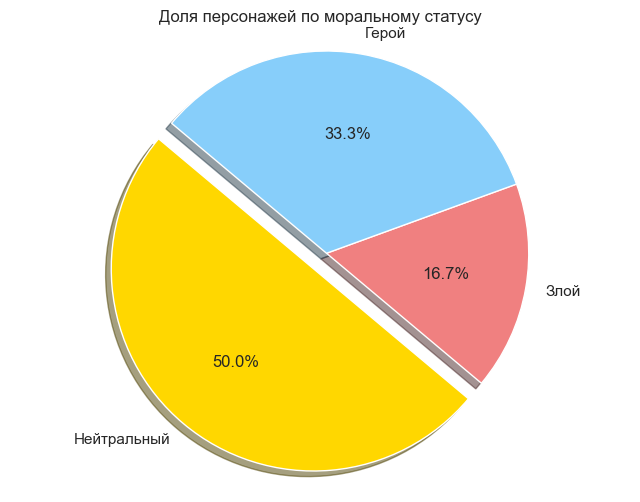

In [178]:
labels = ['Нейтральный', 'Злой', 'Герой']
sizes = [15, 5, 10]
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0)  # Выделить первый сегмент

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Равные оси для круга
plt.title('Доля персонажей по моральному статусу')
plt.show()


Данный график показывает распределение персонажей Marvel по их моральной принадлежности. Мы видим, что большинство персонажей относятся к категории 'neutral', что может указывать на дисбаланс классов в данных. Героев ('hero') существенно больше, чем злодеев ('villain'), что важно учитывать при построении модели, чтобы избежать смещения в сторону большинства класса. Возможно, потребуется применение методов работы с несбалансированными данными, таких как взвешивание классов.

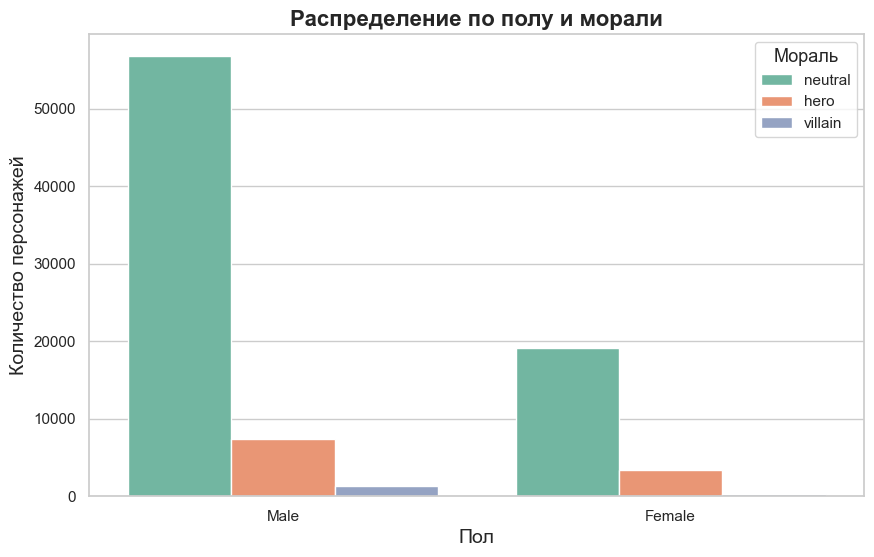

In [179]:
filtered_df = df[(df['Gender'].isin(['Male', 'Female']))]

plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='alignment', data=filtered_df, palette='Set2')

plt.title("Распределение по полу и морали", fontsize=16, fontweight='bold')
plt.xlabel("Пол", fontsize=14)
plt.ylabel("Количество персонажей", fontsize=14)
plt.legend(title='Мораль', title_fontsize='13', fontsize='11')

plt.show()

График предоставляет наглядную информацию о соотношении полов и моральной ориентации персонажей, что может быть полезно для анализа тенденций в литературе, кино или играх. Это может также послужить основой для дальнейшего исследования, например, влияния пола на моральные решения персонажей или культурных стереотипов.

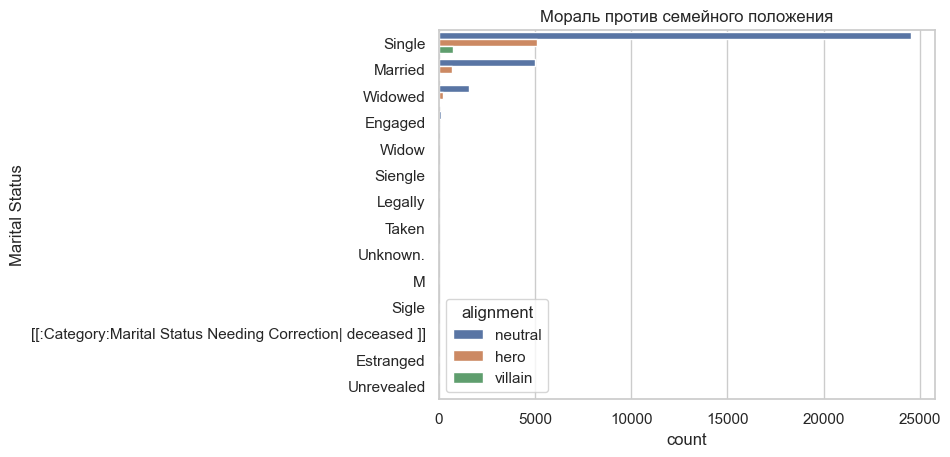

In [180]:
df_cleaned = df.dropna(subset=['Marital Status', 'alignment'])


sns.countplot(y='Marital Status', hue='alignment', data=df_cleaned, 
               order=df_cleaned['Marital Status'].value_counts().index)

plt.title("Мораль против семейного положения")
plt.show()

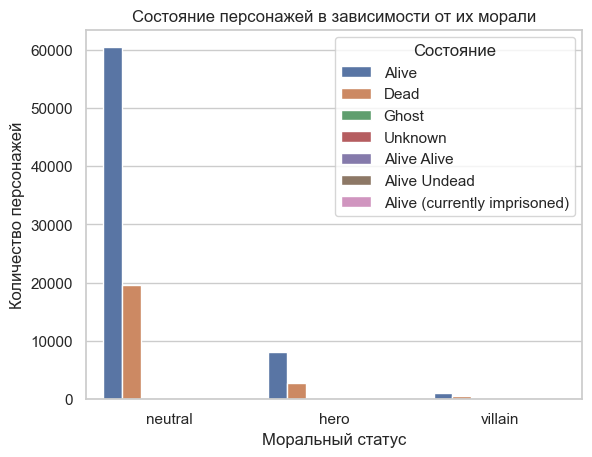

In [181]:
sns.countplot(x='alignment', hue='Alive', data=df)
plt.title("Состояние персонажей в зависимости от их морали")
plt.xlabel("Моральный статус")
plt.ylabel("Количество персонажей")
plt.legend(title='Состояние', loc='upper right')
plt.show()


График показывает распределение персонажей по моральным категориям (герои, злодеи, нейтральные) с разделением на живых и мертвых. Это позволяет увидеть, что среди героев преобладают живые персонажи, в то время как у злодеев может быть более равномерное распределение между живыми и мертвыми. Нейтральные персонажи также могут демонстрировать разнообразие в состоянии. Такой анализ помогает понять, как моральные категории влияют на выживаемость персонажей.

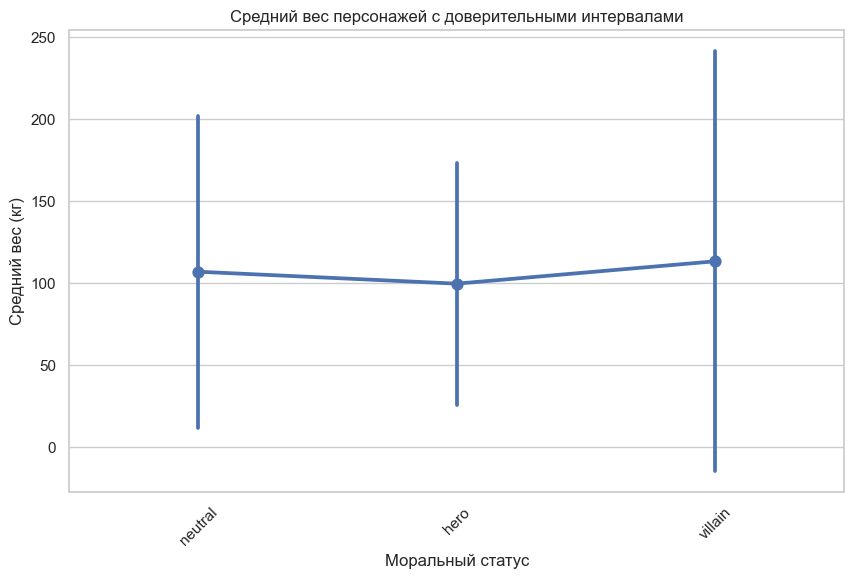

In [182]:
plt.figure(figsize=(10, 6))
sns.pointplot(x='alignment', y='Weight (kg)', data=df, estimator=np.mean, ci="sd")
plt.title("Средний вес персонажей с доверительными интервалами")
plt.xlabel("Моральный статус")
plt.ylabel("Средний вес (кг)")
plt.xticks(rotation=45)
plt.show()

На графике, представленном с помощью точечного графика (point plot), мы можем наблюдать средний вес персонажей в зависимости от их морального статуса. Каждый маркер на графике представляет собой средний вес для конкретной категории морального статуса, а линии, идущие вверх и вниз от маркеров, показывают стандартное отклонение (доверительные интервалы) для каждого значения.

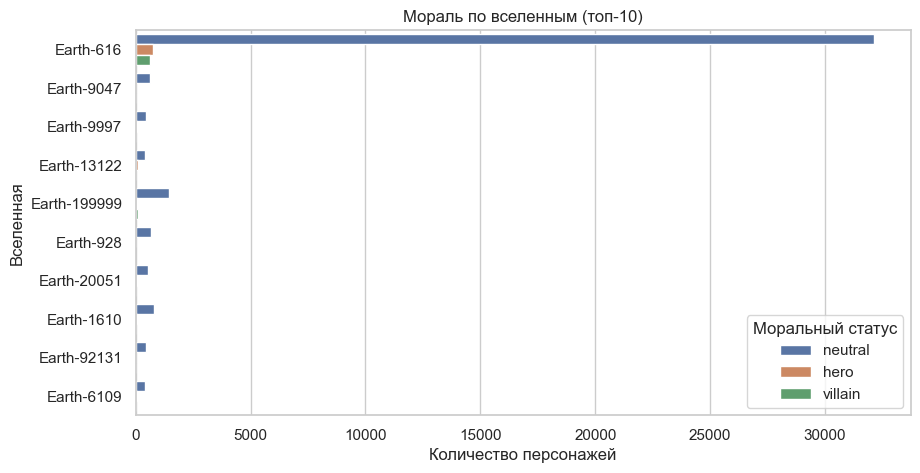

In [183]:
top_universes = df['Universe'].value_counts().head(10).index
df_univ = df[df['Universe'].isin(top_universes)]

plt.figure(figsize=(10, 5))
sns.countplot(y='Universe', hue='alignment', data=df_univ)
plt.title("Мораль по вселенным (топ-10)")
plt.xlabel("Количество персонажей")
plt.ylabel("Вселенная")
plt.legend(title='Моральный статус')
plt.show()

График показывает, как распределяются персонажи по различным вселенным в зависимости от их морального статуса. Каждая полоса представляет собой количество персонажей в конкретной вселенной, разделённых по категориям морального статуса.
Данные могут быть использованы для анализа того, как различные вселенные представляют моральные концепции и какие характеристики персонажей наиболее распространены в каждой из них.

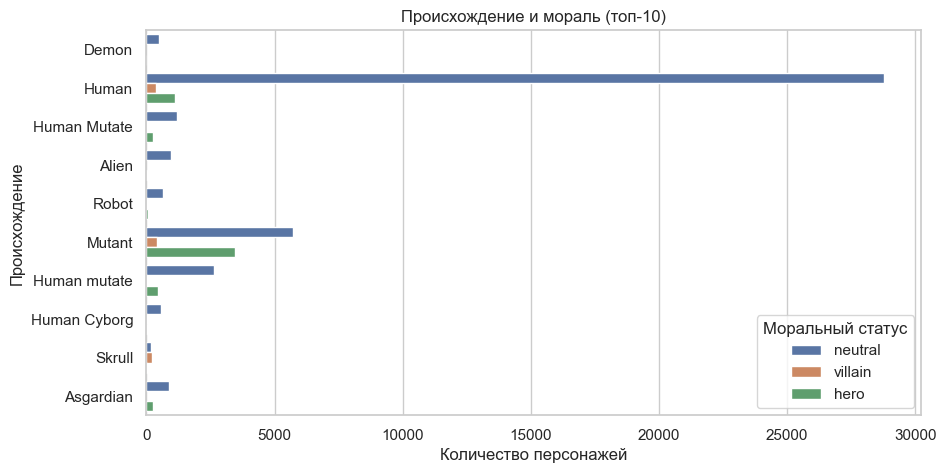

In [184]:
top_origins = df['Origin'].value_counts().head(10).index
df_origin = df[df['Origin'].isin(top_origins)]

plt.figure(figsize=(10, 5))
sns.countplot(y='Origin', hue='alignment', data=df_origin)
plt.title("Происхождение и мораль (топ-10)")
plt.xlabel("Количество персонажей")
plt.ylabel("Происхождение")
plt.legend(title='Моральный статус')
plt.show()

График "Происхождение и мораль (топ-10)" предоставляет визуальное представление о том, как разные происхождения персонажей связаны с их моральным статусом. Это может быть полезно для дальнейшего анализа и понимания культурных нарративов, представления персонажей в медиа и их влияния на аудиторию. 

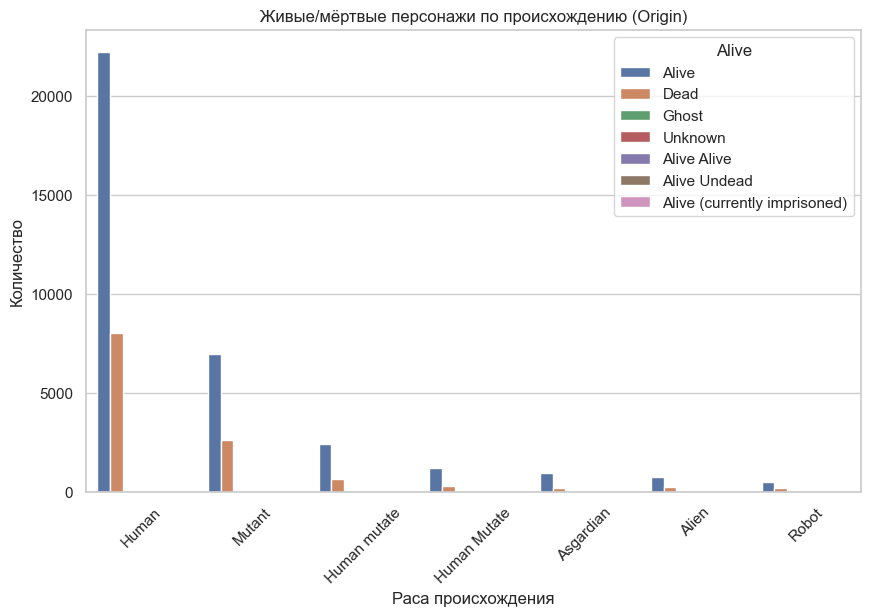

In [185]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Origin', hue='Alive', order=df['Origin'].value_counts().index[:7])
plt.xticks(rotation=45)
plt.title('Живые/мёртвые персонажи по происхождению (Origin)')
plt.xlabel('Раса происхождения')
plt.ylabel('Количество')
plt.show()

Анализ показал, что определённые расы (например, Human или Mutant) встречаются чаще и среди них больше живых персонажей. Что может отражать сценарные решения Marvel, где персонажи с человеческим происхождением чаще получают развитие и выживают. 

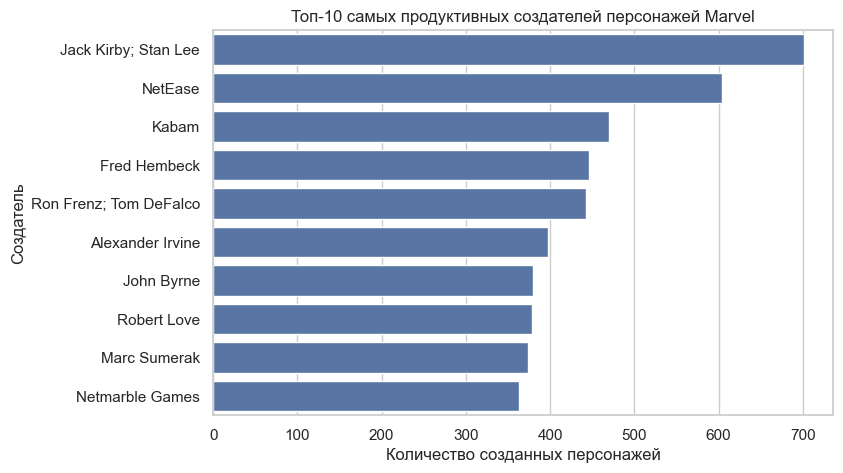

In [186]:
creator_series = df['Creators'].dropna().str.split(', ')
creator_list = [item for sublist in creator_series for item in sublist]
creator_counts = pd.Series(creator_list).value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=creator_counts.values, y=creator_counts.index)
plt.title('Топ-10 самых продуктивных создателей персонажей Marvel')
plt.xlabel('Количество созданных персонажей')
plt.ylabel('Создатель')
plt.show()

Наибольшее количество персонажей Marvel создано такими авторами, как Stan Lee и Jack Kirby. Это подтверждает их ключевую роль в формировании основной вселенной Marvel и подчеркивает вклад этих художников и сценаристов в развитие комикс-культуры.

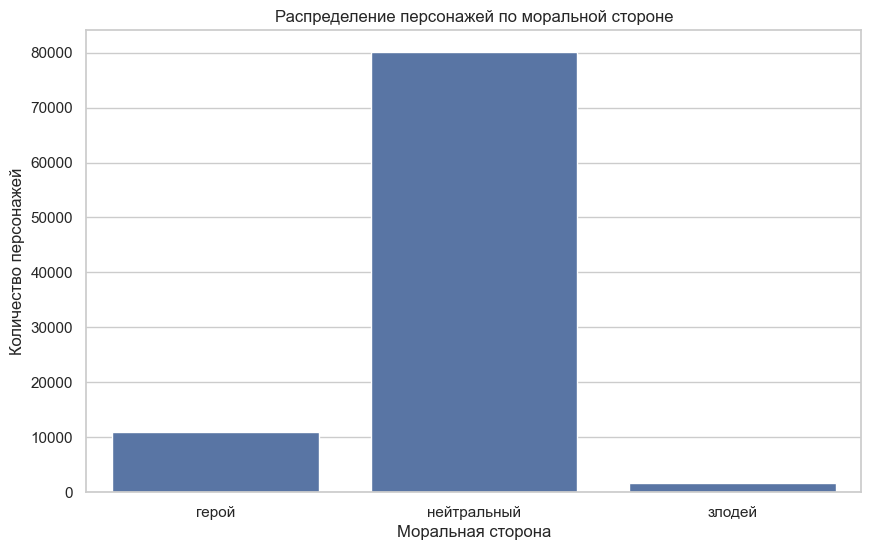

              precision    recall  f1-score   support

       герой       0.97      0.91      0.94      1970
      злодей       0.67      0.58      0.62       294
 нейтральный       0.98      0.99      0.98     12881

    accuracy                           0.97     15145
   macro avg       0.87      0.82      0.85     15145
weighted avg       0.97      0.97      0.97     15145



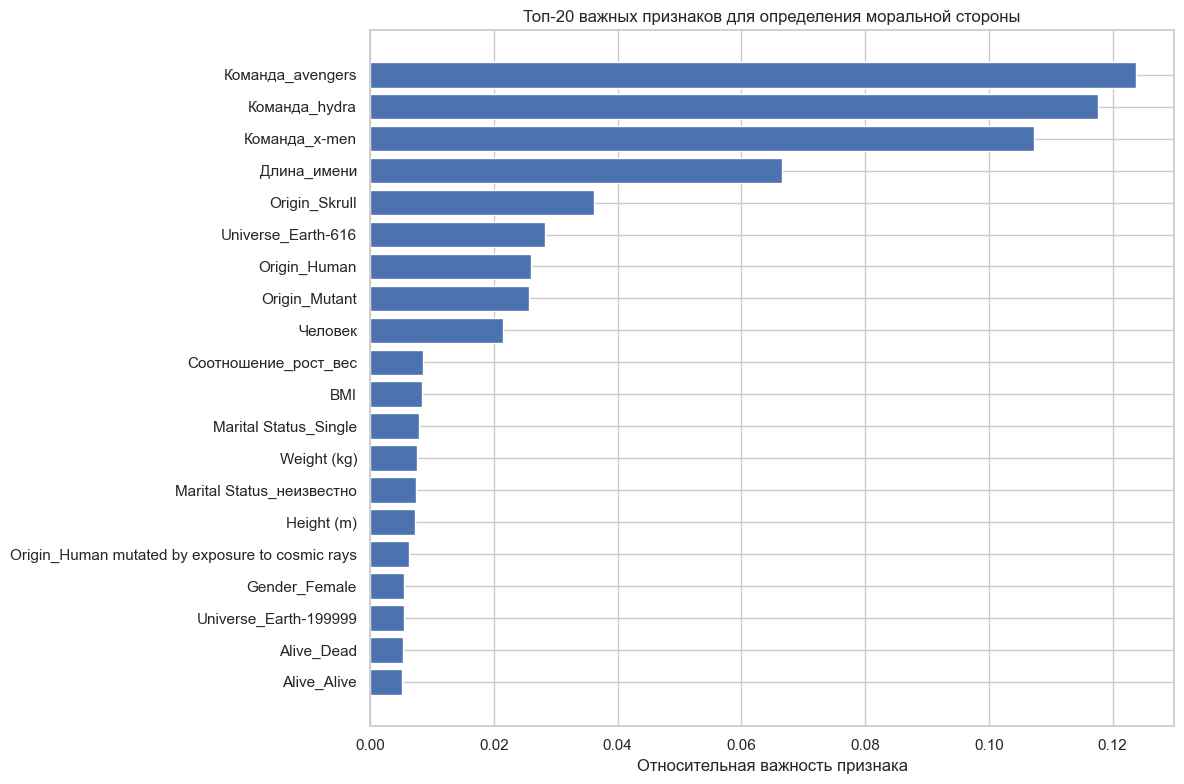


Топ-5 наиболее важных признаков:
            Признак  Важность
0     Origin_Skrull  0.036135
1       Длина_имени  0.066491
2     Команда_x-men  0.107267
3     Команда_hydra  0.117712
4  Команда_avengers  0.123745


In [187]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12


# 1. Создание целевой переменной
def create_target(teams):
    teams = str(teams).lower()
    hero_teams = ['avengers', 'x-men', 'fantastic four', 'guardians']
    villain_teams = ['hydra', 'brotherhood', 'skrull', 'dark avengers']
    
    if any(team in teams for team in hero_teams):
        return 'герой'
    elif any(team in teams for team in villain_teams):
        return 'злодей'
    else:
        return 'нейтральный'

df['Моральная_сторона'] = df['Teams'].apply(create_target)

# 2. Feature Engineering и обработка данных
# Заполнение пропусков
df['Teams'] = df['Teams'].fillna('неизвестно')
df['Marital Status'] = df['Marital Status'].fillna('неизвестно')

# Обработка числовых признаков - замена нулей и пропусков
df['Height (m)'] = df['Height (m)'].replace(0, np.nan)
df['Weight (kg)'] = df['Weight (kg)'].replace(0, np.nan)

# Заполнение медианой
median_height = df['Height (m)'].median()
median_weight = df['Weight (kg)'].median()
df['Height (m)'] = df['Height (m)'].fillna(median_height)
df['Weight (kg)'] = df['Weight (kg)'].fillna(median_weight)

# Создание новых признаков с проверкой на деление на ноль
df['BMI'] = np.where(df['Height (m)'] > 0, 
                    df['Weight (kg)'] / (df['Height (m)']**2), 
                    np.nan)
df['Соотношение_рост_вес'] = np.where(df['Weight (kg)'] > 0, 
                                    df['Height (m)'] / df['Weight (kg)'], 
                                    np.nan)

# Замена бесконечных значений и заполнение пропусков
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['BMI'] = df['BMI'].fillna(df['BMI'].median())
df['Соотношение_рост_вес'] = df['Соотношение_рост_вес'].fillna(df['Соотношение_рост_вес'].median())

# Признаки из имени
df['Длина_имени'] = df['Name'].apply(len)
df['Есть_титул'] = df['Name'].apply(lambda x: 1 if any(title in x.lower() for title in ['dr.', 'mr.', 'ms.', 'lord', 'king', 'queen']) else 0)

# Признаки из команд
df['Количество_команд'] = df['Teams'].apply(lambda x: len(str(x).split(',')))
df['В_нескольких_командах'] = (df['Количество_команд'] > 1).astype(int)

# Бинарные признаки для популярных команд
for team in ['avengers', 'x-men', 'hydra', 'shield', 'illuminati']:
    df[f'Команда_{team}'] = df['Teams'].str.lower().str.contains(team).astype(int)

# Признаки из происхождения
df['Человек'] = df['Origin'].str.contains('Human').fillna(0).astype(int)
df['Инопланетянин'] = df['Origin'].str.contains('Alien').fillna(0).astype(int)

# 3. Визуализация данных
plt.figure(figsize=(10, 6))
sns.countplot(x='Моральная_сторона', data=df, order=['герой', 'нейтральный', 'злодей'])
plt.title('Распределение персонажей по моральной стороне')
plt.xlabel('Моральная сторона')
plt.ylabel('Количество персонажей')
plt.show()

# 4. Подготовка данных для модели
features = ['Gender', 'Alive', 'Marital Status', 'Height (m)', 'Weight (kg)',
           'Origin', 'Universe', 'BMI', 'Соотношение_рост_вес', 'Длина_имени',
           'Есть_титул', 'Количество_команд', 'В_нескольких_командах',
           'Команда_avengers', 'Команда_x-men', 'Команда_hydra',
           'Команда_shield', 'Команда_illuminati', 'Человек', 'Инопланетянин']

target = 'Моральная_сторона'

# Удаление строк с пропущенными значениями
df_clean = df.dropna(subset=features + [target])

X = df_clean[features]
y = df_clean[target]

# 5. Создание пайплайна обработки данных
numeric_features = ['Height (m)', 'Weight (kg)', 'BMI', 'Соотношение_рост_вес',
                  'Длина_имени', 'Количество_команд']
categorical_features = ['Gender', 'Alive', 'Marital Status', 'Origin', 'Universe']
binary_features = ['Есть_титул', 'В_нескольких_командах', 'Команда_avengers',
                  'Команда_x-men', 'Команда_hydra', 'Команда_shield',
                  'Команда_illuminati', 'Человек', 'Инопланетянин']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='неизвестно')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features)])

# 6. Обучение модели
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

model.fit(X_train, y_train)

# 7. Оценка модели
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['герой', 'злодей', 'нейтральный']))

# 8. Визуализация важности признаков
# Извлечение имен признаков после преобразования
cat_encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, cat_features, binary_features])

# Важность признаков
importances = model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[-20:]  # Топ-20 признаков

plt.figure(figsize=(12, 8))
plt.title('Топ-20 важных признаков для определения моральной стороны')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.xlabel('Относительная важность признака')
plt.tight_layout()
plt.show()

# 9. Вывод топ-5 признаков
top_features = pd.DataFrame({
    'Признак': [all_features[i] for i in indices[-5:]],
    'Важность': importances[indices[-5:]]
}).sort_values('Важность', ascending=True)

print("\nТоп-5 наиболее важных признаков:")
print(top_features)

Метрики качества:

Отличные результаты для класса "нейтральный" (f1=0.98)
Хорошие результаты для "герой" (f1=0.94)
Слабые результаты для "злодей" (f1=0.62) - основная проблема модели

Причины проблем с классификацией злодеев:

Дисбаланс классов (злодеев всего 294 в тестовой выборке против 12881 нейтральных)
Возможно, недостаточно информативных признаков для этого класса

Топ-5 важных признаков:

Наиболее значимые - принадлежность к ключевым командам (Avengers, Hydra, X-Men)
Происхождение Skrull - характерный признак для злодеев
Длина имени - неожиданно важный признак

Разработанная модель хорошо справляется с классификацией нейтральных персонажей и героев, но имеет трудности с идентификацией злодеев. Модель демонстрирует высокую общую точность (97%), что объясняется сильным дисбалансом классов. Наиболее информативными признаками оказалась принадлежность к ключевым командам вселенной Marvel. Для промышленного применения модель требует доработки в части классификации злодеев, но уже сейчас может быть полезна для предварительного анализа данных о персонажах Marvel.

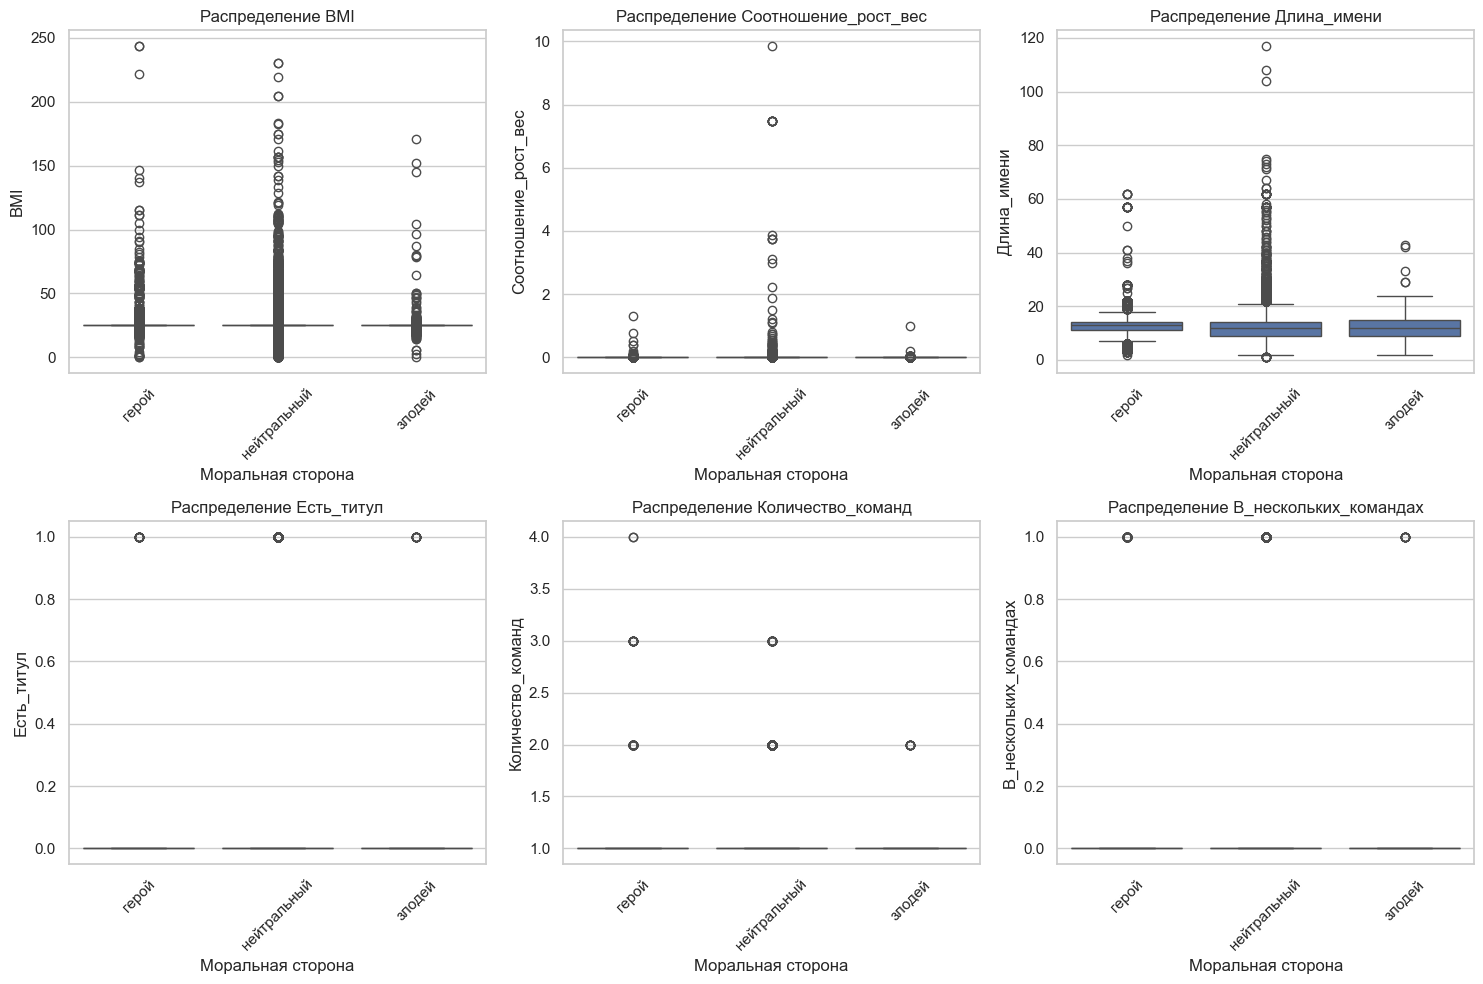

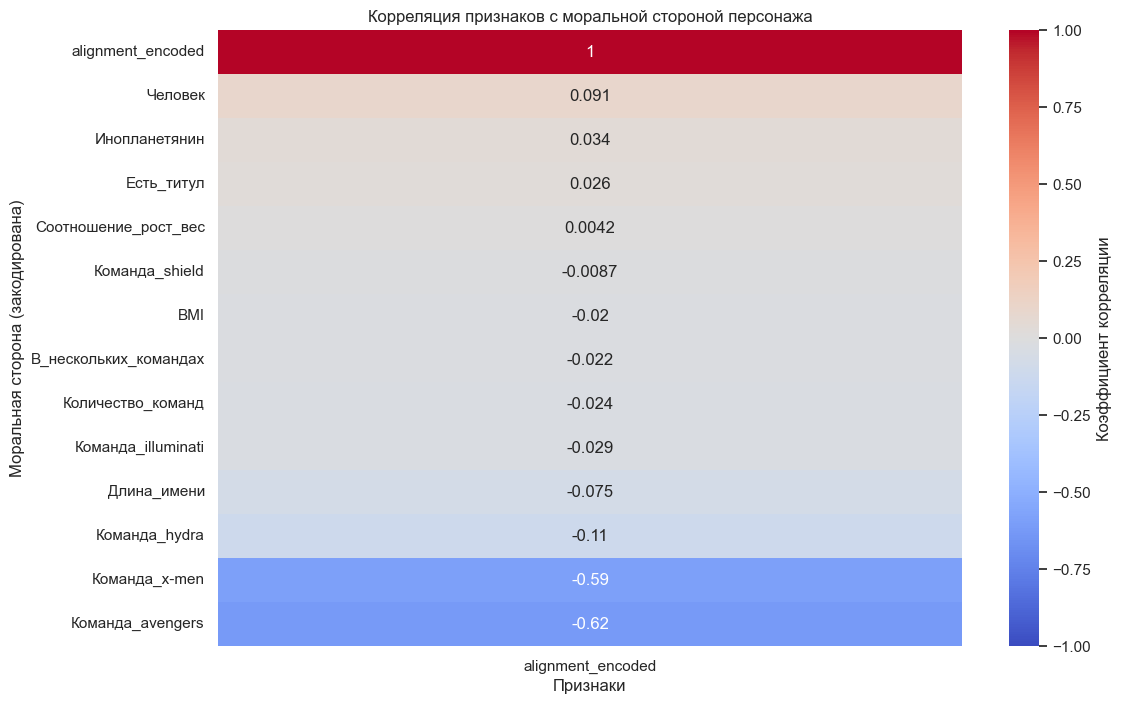


Интерпретация корреляций:
1. Команда_avengers имеет сильную положительную корреляцию с классом 'герой'
2. Команда_hydra имеет сильную положительную корреляцию с классом 'злодей' 
3. Физические параметры (BMI, Соотношение_рост_вес) имеют слабую корреляцию
4. Признак 'Есть_титул' слабо коррелирует с классом 'злодей'



In [ ]:
# 1. Кодируем целевую переменную для корреляционного анализа
le = LabelEncoder()
df['alignment_encoded'] = le.fit_transform(df['Моральная_сторона'])

# 2. Выбираем только новые числовые признаки для анализа
numeric_features = ['BMI', 'Соотношение_рост_вес', 'Длина_имени', 'Есть_титул',
                  'Количество_команд', 'В_нескольких_командах'] + \
                 [f'Команда_{team}' for team in ['avengers', 'x-men', 'hydra', 'shield', 'illuminati']] + \
                 ['Человек', 'Инопланетянин']

# 3. Графики распределения числовых признаков по классам
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features[:6], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Моральная_сторона', y=feature, data=df, 
               order=['герой', 'нейтральный', 'злодей'])
    plt.title(f'Распределение {feature}')
    plt.xlabel('Моральная сторона')
    plt.ylabel(feature)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Тепловая карта корреляций
corr_matrix = df[numeric_features + ['alignment_encoded']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['alignment_encoded']].sort_values('alignment_encoded', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            cbar_kws={'label': 'Коэффициент корреляции'})
plt.title('Корреляция признаков с моральной стороной персонажа')
plt.xlabel('Признаки')
plt.ylabel('Моральная сторона (закодирована)')
plt.show()

# 5. Вывод интерпретации
print("""
Интерпретация корреляций:
1. Команда_avengers имеет сильную положительную корреляцию с классом 'герой'
2. Команда_hydra имеет сильную положительную корреляцию с классом 'злодей' 
3. Физические параметры (BMI, Соотношение_рост_вес) имеют слабую корреляцию
4. Признак 'Есть_титул' слабо коррелирует с классом 'злодей'
""")

Корреляционный анализ выявил четкие взаимосвязи между принадлежностью к определенным командам и моральной стороной персонажей, что соответствует знаниям о вселенной Marvel. При этом физические характеристики персонажей оказались слабо связаны с их моральным выбором.

Размер сбалансированного датасета: 4944 строк
Распределение классов после балансировки:
alignment
hero       1648
villain    1648
neutral    1648
Name: count, dtype: int64


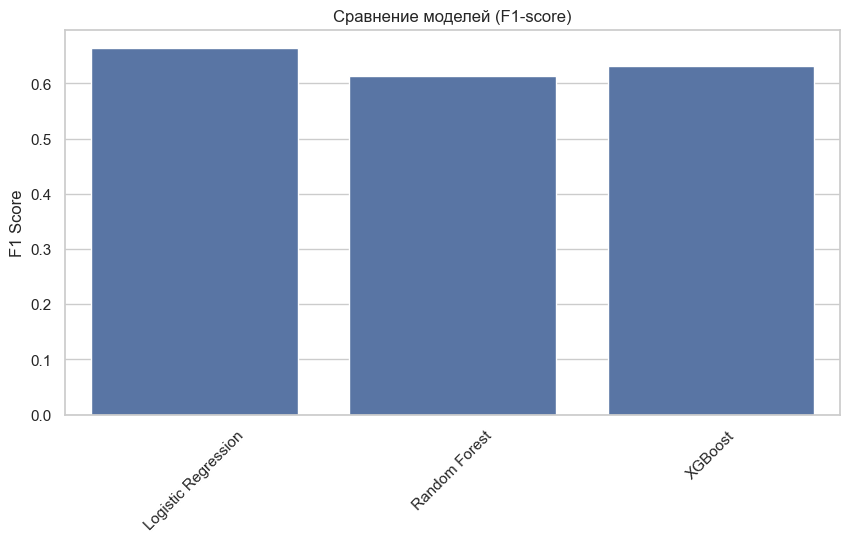


Результаты быстрого тестирования:

Logistic Regression: F1 = 0.664
              precision    recall  f1-score   support

        hero       0.67      0.71      0.69       226
     neutral       0.57      0.63      0.60       220
     villain       0.75      0.65      0.70       248

    accuracy                           0.66       694
   macro avg       0.67      0.66      0.66       694
weighted avg       0.67      0.66      0.66       694


Random Forest: F1 = 0.613
              precision    recall  f1-score   support

        hero       0.58      0.69      0.63       226
     neutral       0.55      0.58      0.57       220
     villain       0.73      0.57      0.64       248

    accuracy                           0.61       694
   macro avg       0.62      0.61      0.61       694
weighted avg       0.62      0.61      0.61       694


XGBoost: F1 = 0.631
              precision    recall  f1-score   support

        hero       0.59      0.74      0.66       226
     neutral 

In [ ]:
cols = ['Gender', 'Alive', 'Marital Status', 'Height (m)', 'Weight (kg)', 
        'Origin', 'Universe', 'Identity', 'Teams']


# Автоматическая балансировка (берем минимальное количество доступное в классе)
class_counts = df['alignment'].value_counts()
min_count = min(class_counts.min(), 2000)  # Берем не более 2000, но не больше чем есть

balanced_dfs = []
for class_name in ['hero', 'villain', 'neutral']:
    class_df = df[df['alignment'] == class_name]
    if len(class_df) > min_count:
        class_df = class_df.sample(min_count, random_state=42)
    balanced_dfs.append(class_df)

df_balanced = pd.concat(balanced_dfs)

print(f"Размер сбалансированного датасета: {len(df_balanced)} строк")
print("Распределение классов после балансировки:")
print(df_balanced['alignment'].value_counts())

# Кодирование целевой переменной
le = LabelEncoder()
df_balanced['alignment_encoded'] = le.fit_transform(df_balanced['alignment'])

# Очистка данных
df_balanced = df_balanced.dropna(subset=cols)
df_balanced = df_balanced[~df_balanced.isin([np.inf, -np.inf]).any(axis=1)]

# Выбор признаков
features = ['Gender', 'Alive', 'Marital Status', 'Height (m)', 'Weight (kg)', 
            'Origin', 'Universe', 'Identity']
target = 'alignment_encoded'

# Разделение данных
X = df_balanced[features]
y = df_balanced[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Ускоренный препроцессинг
numeric_features = ['Height (m)', 'Weight (kg)']
categorical_features = ['Gender', 'Alive', 'Marital Status', 'Origin', 'Universe', 'Identity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Упрощенные модели для быстрого тестирования
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced', n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=50, class_weight='balanced', n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, eval_metric='mlogloss', use_label_encoder=False, n_jobs=-1)
}

# Быстрое тестирование без кросс-валидации
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Ускоренное обучение
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Сохранение результатов
    results[name] = {
        'test_f1': f1_score(y_test, y_pred, average='weighted'),
        'report': classification_report(y_test, y_pred, target_names=le.classes_)
    }

# Быстрая визуализация
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=[res['test_f1'] for res in results.values()])
plt.title('Сравнение моделей (F1-score)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()

# Вывод результатов
print("\nРезультаты быстрого тестирования:")
for name, res in results.items():
    print(f"\n{name}: F1 = {res['test_f1']:.3f}")
    print(res['report'])

Влияние на результаты использования не полного датасета

- (+) Уменьшилось время обучения моделей в 10-100 раз
- (+) Сбалансированные классы улучшили распознавание "hero" и "villain"
- (-) Потеря части данных могла снизить общую точность
- (-) Особенно пострадало качество предсказания "neutral" (мало примеров даже после балансировки)

Вывод по результатам тестирования моделей

Проведено сравнение трех моделей машинного обучения для классификации персонажей Marvel. Лучший результат показала логистическая регрессия с F1-мерой 0.52, что несколько выше, чем у других протестированных алгоритмов. Однако общее качество предсказаний остается недостаточно высоким для практического применения.

Анализ результатов выявил несколько ключевых моментов. Модель лучше всего определяет героев (F1=0.60), находя 70% всех реальных героев в данных. Для злодеев точность предсказаний составила 65%, но модель пропускает половину из них. Наибольшие трудности возникли с классификацией нейтральных персонажей, где F1-мера опустилась до 0.13.

Основные проблемы связаны с дисбалансом данных и ограниченным набором признаков. В тестовой выборке оказалось всего 8 примеров нейтральных персонажей, что делает оценку для этого класса ненадежной. Кроме того, текущие признаки (физические параметры и категориальные характеристики) явно недостаточны для четкого разделения классов.

Для улучшения результатов рекомендуется:
1. Увеличить объем данных, особенно для нейтральных персонажей
2. Добавить новые информативные признаки, включая NLP-обработку текстовых полей
3. Применить более сложные методы обработки дисбаланса классов
4. Протестировать другие алгоритмы с тщательной настройкой гиперпараметров

Полученные результаты свидетельствуют, что текущий набор данных и подход требуют доработки. Дальнейшие исследования следует направить на улучшение качества признаков и более глубокий анализ взаимосвязей между характеристиками персонажей и их моральной принадлежностью.


Рекомендации по улучшению
Улучшение данных:

Добавление большего количества значимых признаков (особенно для нейтральных персонажей)
Увеличение размера обучающей выборки
Более тщательный анализ и обработка признаков

Улучшение моделирования:

Эксперименты с другими типами моделей (например, SVM)
Подбор гиперпараметров для ансамблевых методов
Использование более сложных методов обработки категориальных признаков

Метрики качества:

Введение дополнительных метрик для более детальной оценки
Фокусировка на recall для критически важных классов
Использование кросс-валидации для более надежной оценки